In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from fastai.metrics import *

import matplotlib.pyplot as plt
import csv
from collections import defaultdict, namedtuple
import os
import shutil

import pandas as pd

from sklearn.metrics import confusion_matrix

In [3]:
path = '/home/ubuntu/Data/AI4AXI/'
categories = ['Good_parts', 'Bad_parts']

In [ ]:
def split_val_data(split_rate=0.2):
    val_path = path + "val/"
    train_path = path + "train/"

    print(val_path)
    if os.path.exists(val_path):
        return False
    else:
        # make validation data set path
        os.mkdir(val_path)

        for cat in categories:
            print(cat)
            os.mkdir(val_path + cat)

            train_path_name = os.listdir(train_path + cat)
            # shuffling files
            random.shuffle(train_path_name)

            # split data set
            to_val = train_path_name[:int(len(train_path_name) * split_rate)]

            for f in to_val:
                shutil.move(os.path.join(train_path, cat, f), os.path.join(val_path, cat))

        return True

In [ ]:
# split train/val data
split_data = False  # just done with once at initial time
if split_data:
    split_val_data()

In [4]:
arch=resnet50
sz = 512
bs = 64

tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.2, crop_type=CropType.NO)
#data = ImageClassifierData.from_paths(path, tfms=tfms, test_name='test', bs=bs)
data = ImageClassifierData.from_paths(path, tfms=tfms, bs=bs)

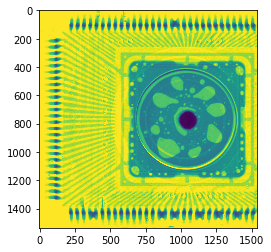

In [5]:
plt.imshow(load_img_id(data.val_ds, 1, path))
plt.show()

In [6]:
y = data.trn_ds.y

In [7]:
print(y[:10])

[0 0 0 0 0 0 0 0 0 0]


In [8]:
from collections import Counter

num_train = 0
label_counts = Counter(y).most_common()
for l, c in label_counts:
    num_train = num_train + c
    print(c, '\t', data.classes[l])
    
print(num_train)

5000 	 Good_parts
960 	 Bad_parts
5960


Bad_parts


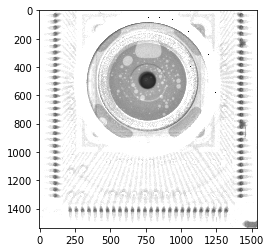

Good_parts


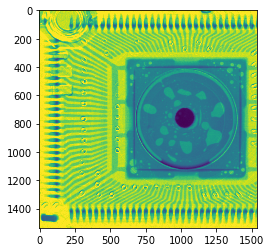

In [9]:
for label in sorted([l for l, c in label_counts], key=lambda p: data.classes[p]):
    i = [i for i, l in enumerate(y) if l == label][0]
    print(data.classes[y[i]])
    plt.imshow(load_img_id(data.trn_ds, i, path))
    plt.show()

In [10]:
flags = cv2.IMREAD_UNCHANGED+cv2.IMREAD_ANYDEPTH+cv2.IMREAD_ANYCOLOR

folder = path + '/train/Bad_parts'

files = os.listdir(folder)
sizes = []

for file in files:
    filename = os.path.join(folder, file)
    img = cv2.imread(filename, flags)
    sizes.append(max(img.shape[0], img.shape[1]))

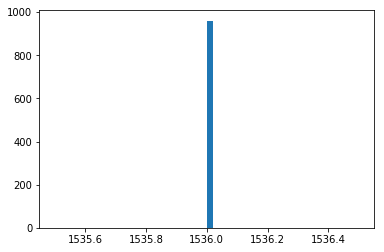

In [11]:
plt.hist(sizes, bins=50)
plt.show()

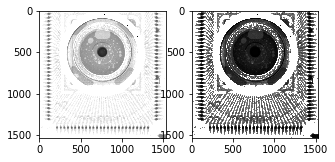

(1536, 1536, 3)


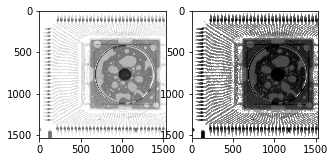

(1536, 1536, 3)


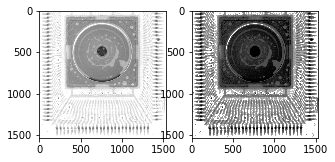

(1536, 1536, 3)


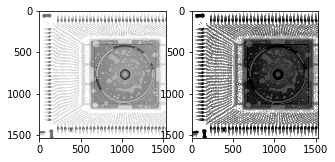

(1536, 1536, 3)


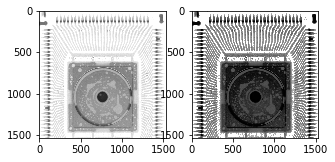

(1536, 1536, 3)


In [12]:
flags = cv2.IMREAD_UNCHANGED+cv2.IMREAD_ANYDEPTH+cv2.IMREAD_ANYCOLOR

folder = path + '/train/Bad_parts'

files = os.listdir(folder)
for i in range(5):
    f = plt.figure(figsize=(5, 5))
    
    filename = os.path.join(folder, files[i])
    img = cv2.imread(filename, flags)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    sp = f.add_subplot(1, 2, 1)
    plt.imshow(img)
    
    img = np.concatenate([np.expand_dims(cv2.equalizeHist(img[:,:,i]), axis=2) for i in range(3)], axis=2)
    
    
    sp = f.add_subplot(1, 2, 2)
    plt.imshow(img)
    plt.show()
    
    print(img.shape)

#Image Augmentation

In [13]:
# Look at examples of image augmentation
def get_augs():
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

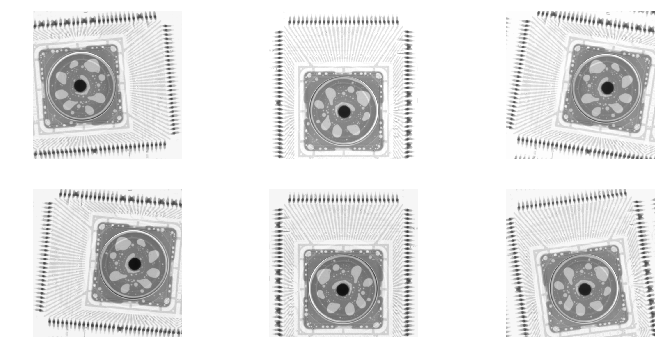

In [14]:
arch=resnet50
sz = 512
bs = 64

#aug_tfms = [RandomRotate(20), RandomLighting(0.8, 0.8)]
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.2, crop_type=CropType.NO)
#tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.2)
data = ImageClassifierData.from_paths(path, tfms=tfms, test_name='test', bs=bs)
#data = ImageClassifierData.from_paths(path, tfms=tfms, bs=bs)

ims = np.stack([get_augs() for i in range(6)])
plots(ims, rows=2)

In [5]:
# Create a learner
learn = ConvLearner.pretrained(arch, data, precompute=False)

In [6]:
wd=5e-4

In [ ]:
def plot_loss_change(sched, sma=1, n_skip=20, y_lim=(-0.01,0.01)):
    """
    Plots rate of change of the loss function.
    Parameters:
        sched - learning rate scheduler, an instance of LR_Finder class.
        sma - number of batches for simple moving average to smooth out the curve.
        n_skip - number of batches to skip on the left.
        y_lim - limits for the y axis.learn.lr_find()
    """
    derivatives = [0] * (sma + 1)
    for i in range(1 + sma, len(learn.sched.lrs)):
        derivative = (learn.sched.losses[i] - learn.sched.losses[i - sma]) / sma
        derivatives.append(derivative)
        
    plt.ylabel("d/loss")
    plt.xlabel("learning rate (log scale)")
    plt.plot(learn.sched.lrs[n_skip:], derivatives[n_skip:])
    plt.xscale('log')
    plt.ylim(y_lim)

In [ ]:
learn.lr_find()

In [ ]:
learn.sched.plot_lr()

In [ ]:
learn.sched.plot()

In [ ]:
plot_loss_change(learn.sched, sma=20, n_skip=20, y_lim=(-0.015, 0.01))

In [ ]:
learn

In [13]:
learn.fit(0.01, 1, wds=wd)

epoch      trn_loss   val_loss   accuracy                  
    0      0.198713   0.067483   0.983333  



[0.06748301063337897, 0.9833333331295567]

In [10]:
learn.save('precompute1')

In [7]:
learn.load('precompute')

In [ ]:
learn.fit(0.01, 2, cycle_len=1, cycle_mult=2, wds=wd)

In [ ]:
learn.save('pre_cycle')

In [ ]:
learn.load('pre_cycle')

In [ ]:
learn.unfreeze()
learn.lr_find()

In [ ]:
learn.sched.plot()

In [ ]:
plot_loss_change(learn.sched, sma=20, n_skip=20, y_lim=(-0.01, 0.01))

In [ ]:
learn.unfreeze()
learn.fit(1e-3, 1, wds=wd)
#learn.fit(0.01, 3)

In [ ]:
learn.save('unfreeze1')

In [ ]:
learn.load('unfreeze1')

In [ ]:
lr=1e-3

In [ ]:
learn.fit(lr, 1, cycle_len=1, cycle_mult=2, wds=wd)
#learn.fit(lr, 4, cycle_len=1, cycle_mult=2)

In [ ]:
learn.sched.plot_lr()

In [ ]:
learn.save('unfreeze_cycle')

In [8]:
log_preds,y = learn.predict_with_targs()
preds = np.exp(log_preds)
pred_labels = np.argmax(preds, axis=1)

[[  14   26]
 [  21 2279]]


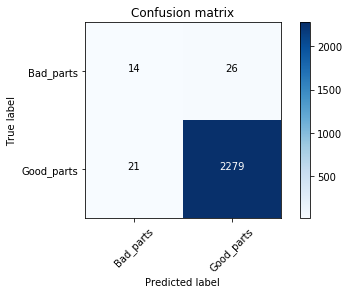

In [9]:
cm = confusion_matrix(y, pred_labels)
plot_confusion_matrix(cm, data.classes)

In [ ]:
results = ImageModelResults(data.val_ds, log_preds)

### Most incorrect

In [ ]:
incorrect = [i for i in range(len(pred_labels)) if pred_labels[i] != y[i]]
c = Counter([(y[i], data.classes[y[i]]) for i in incorrect])
c.most_common(20)

In [ ]:
results.plot_most_incorrect(0)

In [ ]:
results.plot_most_incorrect(1)

### Most correct

In [ ]:
results.plot_most_correct(0)

In [ ]:
results.plot_most_correct(1)

In [ ]:
results.plot_most_correct(1)

### Most uncertain

In [ ]:
results.plot_most_uncertain(1)

In [ ]:
results.plot_most_uncertain(0)

## Test time augmentation (TTA)

In [9]:
log_preds,y = learn.TTA(n_aug=4)
preds = np.mean(np.exp(log_preds),0)

In [10]:
accuracy_np(preds, y)

0.9867521367521368

In [ ]:
accuracy_np(preds, y), metrics.log_loss(y, preds)

In [ ]:
precision(log_preds, y)

In [ ]:
precision_np(preds, y)

In [ ]:
from sklearn.metrics import f1_score

def f1(preds, targs, start=0.17, end=0.24, step=0.01):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return max([f1_score(targs, (preds>th), average='weighted')
                    for th in np.arange(start,end,step)])

In [ ]:
f1(preds, y)

In [ ]:
fbeta_np(preds, y, 1)

In [11]:
preds = np.argmax(preds, axis=1)
print(preds.shape)
print(preds)
print(preds.shape)

(2340,)
[1 0 0 ... 1 1 1]
(2340,)


In [11]:
test_log_predictions, _ = learn.TTA(is_test=True)
test_probs = np.mean(np.exp(test_log_predictions),0)
test_predictions = np.argmax(test_probs, axis=1)
print(test_predictions.shape)
test_predictions_classes = [data.classes[pred] for pred in test_predictions]
test_file_names = learn.data.test_ds.fnames

(1120,)                                      


In [12]:
with open('submission_AXI_1.csv', 'w') as the_file:
    for file_path, prediction in zip(test_file_names, test_predictions_classes):
        print(file_path)
        file_name = file_path.split('/')[-1]
        the_file.write(file_name)
        the_file.write(",")
        if prediction == "Good_parts":
            the_file.write("OK")
        else:
            the_file.write("NOK")
        the_file.write("\n")
the_file.close()

from IPython.display import FileLink
FileLink('submission_AXI_1.csv')

test/SFT.ER100_2851594715200.1030101F13EB17L210013.2.png
test/SFT.ER100_2851557840200.103002155FB518A02004F.6.png
test/SFT.ER100_2851577412200.14973115311018A265193.13.png
test/SFT.ER100_2851605203200.1573011F13EB17K28031C.6.png
test/SFT.ER100_2851645102200.1258011F13EB17K2914B6.4.png
test/SFT.ER100_2851533115200.1190011F13EB18A1100A0.6.png
test/SFT.ER100_2851594715200.1030101F13EB17L210037.2.png
test/SFT.ER100_2851645102200.1258011F13EB17K2914CE.4.png
test/SFT.ER100_2851533415200.11900115311018B05A12F.3.png
test/SFT.ER100_2851557840200.103002155FB517L0305A1.14.png
test/SFT.ER100_2851577412200.14973115311018A2651A5.10.png
test/SFT.ER100_2851586912200.06433115311017K288211.7.png
test/SFT.ER100_2851642600200.1174011F1AAF17J270037.3.png
test/SFT.ER100_2851557840200.103002155FB518A02003D.6.png
test/SFT.ER100_2851533115200.1190011F13EB18A1100AC.2.png
test/SFT.ER100_2851557840200.103002155FB518A02004F.3.png
test/SFT.ER100_2851586912200.06433115311017K288211.6.png
test/SFT.ER100_2851557832200

/home/ubuntu/srieraam/F2ST1/submission_AXI.csv

In [ ]:
# Retrain on the training set + validation set

In [ ]:
from collections import Counter

def winner(input): 
  
     # convert list of candidates into dictionary 
     # output will be likes candidates = {'A':2, 'B':4} 
     votes = Counter(input)
     #print(votes)
       
     # create another dictionary and it's key will 
     # be count of votes values will be name of  
     # candidates 
     dict = {} 
  
     for value in votes.values(): 
  
          # initialize empty list to each key to  
          # insert candidate names having same  
          # number of votes  
          dict[value] = [] 
  
     for (key,value) in votes.items(): 
          dict[value].append(key) 
  
     # sort keys in descending order to get maximum  
     # value of votes 
     maxVote = sorted(dict.keys(),reverse=True)[0] 
  
     # check if more than 1 candidates have same  
     # number of votes. If yes, then sort the list 
     # first and print first element 
     if len(dict[maxVote])>1:
         return sorted(dict[maxVote])[0]
     else:
         return dict[maxVote][0]

In [ ]:
import pandas as pd

submission1 = './submission23.csv'
submission2 = './submission22.csv'
submission3 = './submission21.csv'
submission4 = './submission18.csv'
submission5 = './submission17.csv'
submission6 = './submission17.csv'
submission7 = './submission16.csv'

counter = 0

df1 = pd.read_csv(submission1)
df2 = pd.read_csv(submission2)
df3 = pd.read_csv(submission3)
df4 = pd.read_csv(submission4)
df5 = pd.read_csv(submission5)
df6 = pd.read_csv(submission6)
df7 = pd.read_csv(submission7)

classes = []
speciesList = []

for i in range(0, len(df1)):
    classes.append(winner([df1['species'][i], df2['species'][i], df3['species'][i], df4['species'][i], df5['species'][i], df6['species'][i], df7['species'][i]]))

with open('submission.csv', 'w') as the_file:
    the_file.write('file,species\n')
    for file_path, prediction in zip(test_file_names, classes):
        file_name = file_path.split('/')[-1]
        the_file.write(file_name)
        the_file.write(",")
        the_file.write(prediction)
        the_file.write("\n")
the_file.close()

from IPython.display import FileLink
FileLink('submission.csv')

In [ ]:
# Testing on the test set

In [ ]:
true_test_labels = {a.filename: a.label for a in test_annotations}
class_indexes = {c: i for i, c in enumerate(data.classes)}
filenames = [filepath[filepath.find('/') + 1:] for filepath in data.test_ds.fnames]
labels = [str(true_test_labels[filename]) for filename in filenames]
y_true = np.array([class_indexes[label] for label in labels])

In [ ]:
log_preds = learn.predict(is_test=True)
preds = np.exp(log_preds)
accuracy_np(preds, y_true)

In [ ]:
log_preds,_ = learn.TTA(n_aug=20, is_test=True)
preds = np.mean(np.exp(log_preds),0)
accuracy_np(preds, y_true)